# Project 1: Cyclic Coordinate Descent for Regularized Logistic Regression

## Datasets

dataset1

dataset2

dataset3

dataset4

dataset_synthetic

In [45]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

## dataset1

## dataset2

## dataset3

## dataset4

## Synthetic dataset

In [41]:
def generate_synthetic_data(p, n, d, g):
    """
    Generate a synthetic dataset based on the given parameters.
    
    Parameters
    ----------
        p: float
            Prior probability for class Y=1.
        n: int
            Number of observations.
        d:  int
            Dimensionality of feature space.
        g: float 
            Covariance decay factor.
    
    Returns
    ----------
        DataFrame: A DataFrame containing generated features and class labels.
    """
    
    # Generate binry class variable
    Y = np.random.binomial(1, p, size=n)

    # Define means for multivariate normal distribution
    mean_0 = np.zeros(d)
    mean_1 = np.array([1 / (i + 1) for i in range(d)])

    # Define covariance matrix S
    indices = np.arange(d)
    S = np.array([[g ** np.abs(i - j) for j in indices] for i in indices])
    
    # Create DataFrame
    X = np.array([
        np.random.multivariate_normal(mean_1 if y == 1 else mean_0, S)
        for y in Y
    ])
    columns = [f'X{i+1}' for i in range(d)]
    df = pd.DataFrame(X, columns=columns)
    df['Y'] = Y
    
    return df


In [78]:
p = 0.5
n = 10000
d = 5
g = 0.1

synthetic_df = generate_synthetic_data(p, n, d, g)
synthetic_df.head()

,X1,X2,X3,X4,X5,Y
0,0.544374,-0.948704,-0.921696,0.822097,-0.553486,0
1,0.342765,-0.021391,0.897325,-0.437719,-0.758080,0
2,-0.465409,-0.126490,0.423606,2.935712,1.265766,1
3,0.036103,-1.430249,0.743583,-1.341123,1.974809,0
4,1.922510,0.478072,-0.056049,-0.885558,1.204390,0


In [79]:
synthetic_df[synthetic_df["Y"]==0].describe()

,X1,X2,X3,X4,X5,Y
count,4985.000000,4985.000000,4985.000000,4985.000000,4985.000000,4985.0
mean,-0.005843,0.013012,-0.008966,0.011189,-0.023706,0.0
std,1.008804,1.009712,1.009051,1.017420,0.996470,0.0
min,-3.228552,-3.648926,-3.345775,-3.613802,-3.670821,0.0
25%,-0.695433,-0.658011,-0.693797,-0.671829,-0.691199,0.0
50%,-0.012047,0.017132,-0.013956,0.007224,-0.005686,0.0
75%,0.692315,0.671278,0.667609,0.690285,0.616759,0.0
max,3.692258,4.310026,4.332952,3.475682,3.797591,0.0


In [80]:
synthetic_df[synthetic_df["Y"]==1].describe()

,X1,X2,X3,X4,X5,Y
count,5015.000000,5015.000000,5015.000000,5015.000000,5015.000000,5015.0
mean,0.995014,0.490953,0.306833,0.219753,0.228336,1.0
std,1.000797,1.015712,1.004891,1.003777,0.994056,0.0
min,-2.838056,-3.000079,-3.036036,-3.570806,-3.097657,1.0
25%,0.332011,-0.209926,-0.372153,-0.457985,-0.433391,1.0
50%,0.991025,0.501033,0.303558,0.235016,0.233196,1.0
75%,1.677311,1.192445,0.968752,0.881883,0.897079,1.0
max,5.474773,4.742176,4.081214,3.761513,4.465162,1.0


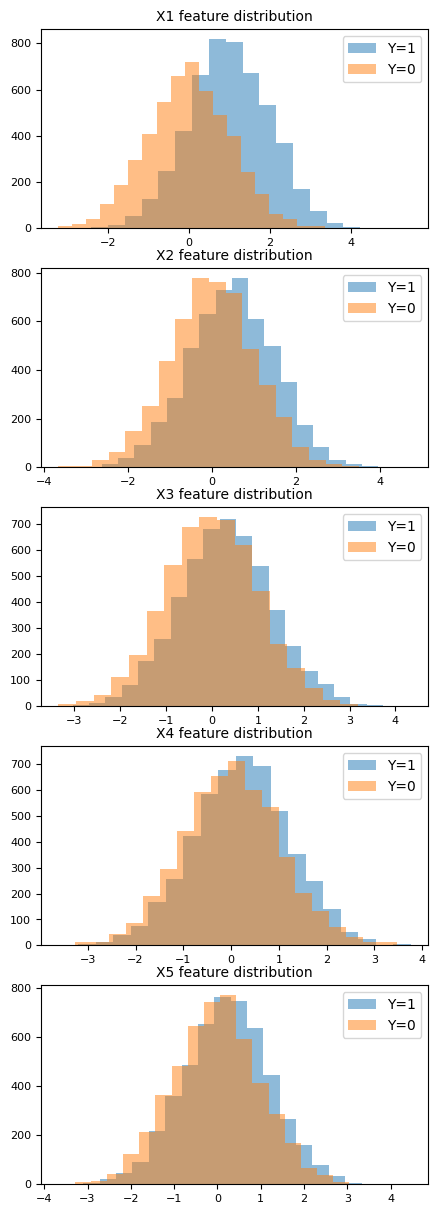

In [109]:
bins = 20

fig = plt.figure(figsize=(5, 15))
for i in range(d): 
    plt.subplot(5, 1, i+1)
    plt.hist(synthetic_df[synthetic_df["Y"]==1][f"X{i+1}"], bins=bins, alpha=0.5, label="Y=1")
    plt.hist(synthetic_df[synthetic_df["Y"]==0][f"X{i+1}"], bins=bins, alpha=0.5, label="Y=0")
    plt.legend(loc='upper right')
    plt.gca().set_title(f"X{i+1} feature distribution", fontsize=10)
    plt.gca().tick_params(labelsize=8)

plt.show()